In [3]:
%load_ext autoreload
%autoreload 2
# Import the relevant modules
import cv2
import numpy as np
import helpers
from objloader_simple import *
from imutils.video import VideoStream
from imutils import resize
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example Image find Squares

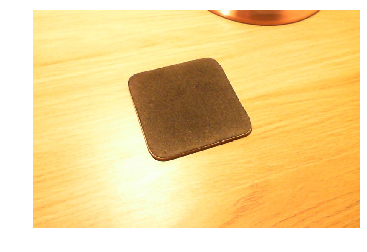

In [40]:
# Function to show images at relevant steps
def plot_image(img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()
    
# Load in our first test image
img = cv2.imread('../data/img/test_image00.jpg',1)

# Convert our colour image to correct RGB channels
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_image(img)

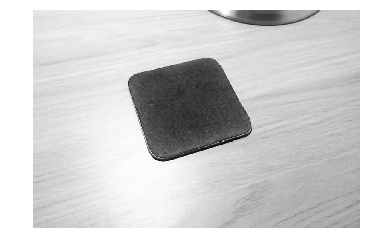

In [31]:
# Convert our image to grayscale
img_g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plot_image(img_g, cmap = plt.cm.gray)

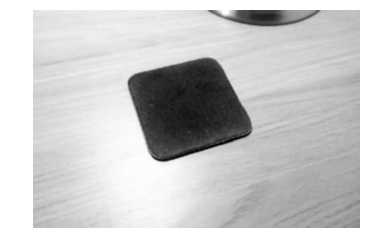

In [32]:
# Apply Gaussian Blur to smooth image
img_b = cv2.GaussianBlur(img_g, (7, 7), 0)
plot_image(img_b, cmap = plt.cm.gray)

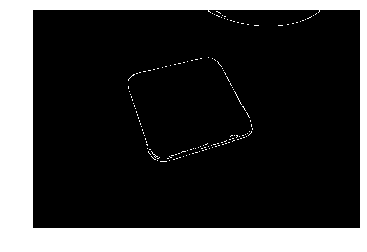

In [33]:
# Canny edge detection; vals are min and max values
edges = cv2.Canny(img_b, 50, 150)
plot_image(edges, cmap = plt.cm.gray)

Found square


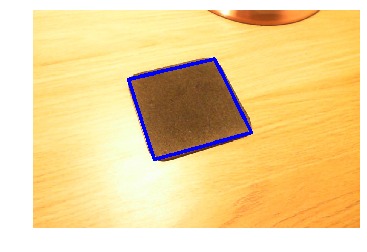

In [34]:
# Find contours in our image
contours = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through contours
for con in contours[1]:
    # This is the contour perimeter, True=closed shape
    perimeter = cv2.arcLength(con, True)
    # Create an approximatation of our contour
    approx = cv2.approxPolyDP(con, 0.1 * perimeter ,True)
    
    if len(approx) == 4:
        # Compute the bounding box of the approximate rectangle
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        
        # Calculate area and solidity
        area = cv2.contourArea(con)
        area_h = cv2.contourArea(cv2.convexHull(con))
        solidity = area / float(area_h)
        
        test_ar = aspect_ratio >= 0.8 and aspect_ratio <= 1.3
        test_dm = w > 50 and h > 50
        test_sl = solidity > 0.9
        
        if test_ar and test_dm and test_sl:
            print("Found square")
            img_box = cv2.drawContours(img, [approx], -1, (0,0,255), 5)
            
plot_image(img_box)

### Find squares in Video
This code block will activate the computer webcam and start trying to identify squares being seen in the image. It will work on multiple squares in the same frame.

In [8]:
# This is set to 1 rather than 0 because of switching webcams
vs = VideoStream(1).start()

while True:
    # Read in a single frame
    frame = vs.read()
    # Resize the video window to be smaller
    frame = resize(frame, width=400)
    
    # Process our image to find squares
    output = helpers.find_squares(frame)
    cv2.imshow('Finding Squares', output)
    
    # If 'Q' is pressed them terminate the video window
    key =  cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        vs.stop()
        cv2.destroyAllWindows()
        break

### Marker Based Image Recognition
Moving on, we now supply a 'marker' image for our code to detect in another image and apply the same bounding box technique.

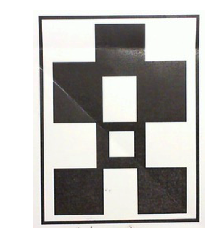

In [62]:
# Load in our marker image
img = cv2.imread('../data/img/test_image01.png',1)

# Convert our colour image to correct RGB channels
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_image(img)

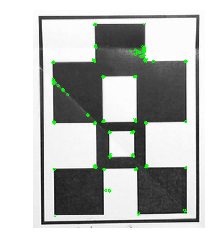

In [63]:
# Initiate ORB detector and find keypoints
orb = cv2.ORB_create()
kp = orb.detect(img, None)

# Compute descriptors
kp, des = orb.compute(img, kp)

# Draw keypoints
img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
features = cv2.drawKeypoints(img_g, kp, img, color=(0,255,0), flags=0)
plot_image(features)

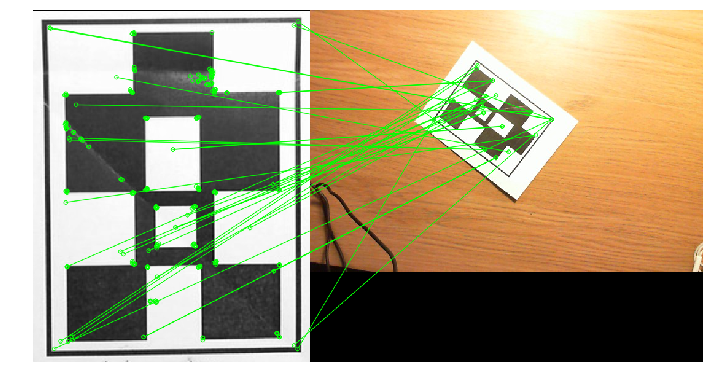

In [64]:
# Load in our scene image
scene = cv2.imread('../data/img/test_image02.jpg',1)
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)

# Computer keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create()
kpm, desm = sift.detectAndCompute(img, None)
kps, dess = sift.detectAndCompute(scene, None)

# Create a matcher object
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match the marker descriptors with the scene descriptors
matches = flann.knnMatch(desm, dess, k=2)

# Sort the matches in order of distance
good = []
for m,n in matches:
    if m.distance < 0.8 * n.distance:
        good.append(m)

# Draw the top 50 matches
drawParameters = dict(matchColor=(0,255,0), singlePointColor=None, flags=2)
feat_match = cv2.drawMatches(img, kpm, scene, kps, good[:], 0, **drawParameters)
fig, ax = plt.subplots(figsize=(12,7))
plot_image(feat_match)

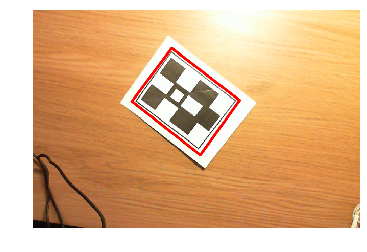

In [65]:
src_pts = np.float32([kpm[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kps[m.trainIdx].pt for m in good]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

h,w,_ = img.shape
pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)

dst = cv2.perspectiveTransform(pts, M)
    
scene_marker = cv2.polylines(scene, [np.int32(dst)], True, 255, 4, cv2.LINE_AA)
    
plot_image(scene_marker)

### Marker Based Video

In [5]:
# This is set to 1 rather than 0 because of switching webcams
vs = VideoStream(1).start()
# Load in marker image
img, sift, kpm, desm, flann = helpers.marker_setup()

while True:
    # Read in a single frame
    frame = vs.read()
    # Resize the video window to be smaller
    frame = resize(frame, width=600)

    # Process our image to find squares
    output = helpers.find_markers(frame, img, sift, kpm, desm, flann)
    cv2.imshow('Finding Squares', output)
    
    # If 'Q' is pressed them terminate the video window
    key =  cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        vs.stop()
        cv2.destroyAllWindows()
        break

### Render Object on Contour

In [4]:
# This is set to 1 rather than 0 because of switching webcams
vs = VideoStream(1).start()
obj = OBJ('../data/models/fox.obj', swapyz=True)

# Load in marker image
img, sift, kpm, desm, flann = helpers.marker_setup()

while True:
    # Read in a single frame
    frame = vs.read()
    # Resize the video window to be smaller
    frame = resize(frame, width=600)

    # Process our image to find squares
    output = helpers.find_markers(frame, img, sift, kpm, desm, flann, obj, render=True)
    cv2.imshow('Finding Squares', output)
    
    # If 'Q' is pressed them terminate the video window
    key =  cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        vs.stop()
        cv2.destroyAllWindows()
        break